In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import cv2
from tqdm.auto import tqdm
import math

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
BATCH_SIZE=64
WINDOW_SIZE=(100, 100)
if(torch.cuda.is_available()):
    DEVICE=torch.device("cuda")
else:
    DEVICE=torch.device("cpu")

In [3]:
LEFT_RIGHT_PAIRS=[(0,3), (1, 2), (4, 9), (5, 8), (6, 7), (10, 10), (12, 12), (11, 13)]
def flip_image(image,**kwargs):
    return np.fliplr(image).copy()
def flip_keypoints(points, **kwargs):
    points = np.array(points)
    flipped_keys = []

    for p in points:
        x, y = p[0], p[1]
        flipped_x = WINDOW_SIZE[0] - x
        flipped_y = y

        rest = p[2:] if len(p) > 2 else []
        flipped_keys.append([flipped_x, flipped_y, *rest])
    for i, j in LEFT_RIGHT_PAIRS:
        flipped_keys[i], flipped_keys[j] = flipped_keys[j], flipped_keys[i]

    return np.array(flipped_keys)


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
TRANSFORM = A.Compose([
    A.Resize(height=WINDOW_SIZE[0], width=WINDOW_SIZE[1]),
    A.Lambda(image=flip_image, keypoints=flip_keypoints, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
from torch.utils import data 
import random
class MyDataset(data.Dataset):
    def __init__(self,
                 mode, 
                 root_images, 
                 root_images_info,
                 train_fraction=0.8, 
                 split_seed=42,
                 transform=None):
        super().__init__()
        rng=random.Random(split_seed)
        image_info=pd.read_csv(root_images_info+"/img_shapes.csv")
        image_info_points=pd.read_csv(root_images_info+"/gt.csv")
        self.paths=list(image_info['img_filename'])
        self.shapes=list(zip(image_info['n_rows'], image_info['n_cols']))
        self.points=[list(row.iloc[1:]) for _, row in image_info_points.iterrows()]
        self.points=list(map(lambda x: [(x[i], x[i+1]) for i in range(0,len(x), 2)], self.points))
        self.paths, self.shapes, self.points = self.filter(self.paths, self.shapes, self.points)
        combined = list(zip(self.paths, self.shapes, self.points))
        rng.shuffle(combined)
        self.paths, self.shapes, self.points = zip(*combined)
        split_train=int(train_fraction*len(self.paths))
        if(mode=="train"):
            self.paths=self.paths[:split_train]
            self.shapes=self.shapes[:split_train]
            self.points=self.points[:split_train]
        elif(mode=="valid"):
            self.paths=self.paths[split_train:]
            self.shapes=self.shapes[split_train:]
            self.points=self.points[split_train:]
        else:
            raise ValueError("Mode is not train or valid")
        self.paths=[f"{root_images}/{path}" for path in self.paths]

        self._transform=transform
    def filter(self, paths, shapes, points):
        ans = []
        for i, point_group in enumerate(points):
            shape = self.shapes[i]
            is_ok = True
            for x, y in point_group:
                if x > shape[0] or x < 0 or y < 0 or y > shape[1]:
                    is_ok = False
            if is_ok:
                ans.append((paths[i], shapes[i], points[i]))
        return zip(*ans)

    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        img_path=self.paths[index]
        label=self.points[index]
        original_label_size=len(label)
        if(self._transform):
            image=np.array(PIL.Image.open(img_path))
            transformed=None
            image_transformed=image
            label_transformed=label
            while(transformed is None or self.filter([""], [image_transformed.shape], [label_transformed])==((), (), ()) or len(label_transformed)!=original_label_size):
                transformed=self._transform(image=image, keypoints=label)
                image_transformed=transformed['image']
                label_transformed=transformed['keypoints']
            image=image_transformed
            label=label_transformed
        else:
            image=np.array(PIL.Image.open(img_path))
        label=np.array(label)
        return image, label

In [6]:
import os
image_dir="./tests/00_test_img_input/train/images"#test is the same as train
file_points="./tests/00_test_img_gt"
ds_train=MyDataset("train", image_dir, file_points, transform=TRANSFORM)
ds_valid=MyDataset("valid", image_dir, file_points, transform=TRANSFORM)

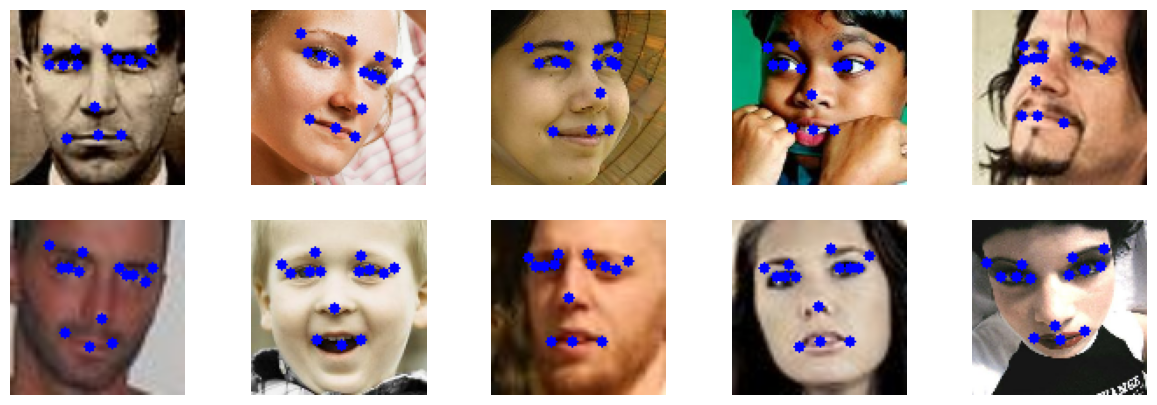

In [7]:

def show_image_points(image, points,color = (0, 0, 255), mean=None, std=None):
    ''' 
    Takes in numy array returns Pil Image with points on them
    '''
    image = image.permute(1, 2, 0).cpu().numpy()
    
    if std is not None and mean is not None:
        image = (image * std.reshape(1, 1, -1)) + mean.reshape(1, 1, -1)
        image = np.clip(image*255, 0, 255)
    image = image.astype(np.uint8)
    r=3
    for point in points:
        point=(int(point[0]), int(point[1]))
        cv2.circle(image, point, r, color, -1)
    return PIL.Image.fromarray(image)
def display_multiple_images(dataset, n=5, mean=None, std=None):
    plt.figure(figsize=(15, 5))
    cols = min(n, 5)
    rows=math.ceil(n/cols)
    for i in range(n):
        image, points=dataset[i]
        image=show_image_points(image, points, mean=mean, std=std)
        plt.subplot(rows,cols, i+1)
        plt.imshow(image)
        plt.axis("off")
display_multiple_images(ds_train, 10)

In [8]:
def calculate_mean_std(ds_train):
    mean=0.
    std=0.
    for image, _ in ds_train:
        img = image.float().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean/=len(ds_train)
    std/=len(ds_train)
    return mean, std
MEAN_DATASET, STD_DATASET = calculate_mean_std(ds_train)
MEAN_DATASET, STD_DATASET

(array([136.91046 , 109.890686,  95.62381 ], dtype=float32),
 array([60.035652, 55.08362 , 52.57623 ], dtype=float32))

In [9]:
TRAIN_TRANSFORM= A.Compose([
    A.Resize(height=WINDOW_SIZE[0], width=WINDOW_SIZE[1]),
    A.Lambda(image=flip_image, keypoints=flip_keypoints, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=MEAN_DATASET.tolist(), std=STD_DATASET.tolist()),
    A.Lambda(image=lambda x, **kwargs: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) if x.ndim == 2 else x), #for grayscale images convert them to rgb
    ToTensorV2()
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))
VALID_TRANSFORM= A.Compose([
    A.Resize(height=WINDOW_SIZE[0], width=WINDOW_SIZE[1]),
    A.Lambda(image=flip_image, keypoints=flip_keypoints, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=MEAN_DATASET.tolist(), std=STD_DATASET.tolist()),
    A.Lambda(image=lambda x, **kwargs: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) if x.ndim == 2 else x), #for grayscale images convert them to rgb
    ToTensorV2()
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))
ds_train=MyDataset("train", image_dir, file_points, transform=TRAIN_TRANSFORM)
ds_valid=MyDataset("valid", image_dir, file_points, transform=VALID_TRANSFORM)

/tmp/ipykernel_635405/2459232704.py:6: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) if x.ndim == 2 else x), #for grayscale images convert them to rgb
/tmp/ipykernel_635405/2459232704.py:14: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) if x.ndim == 2 else x), #for grayscale images convert them to rgb


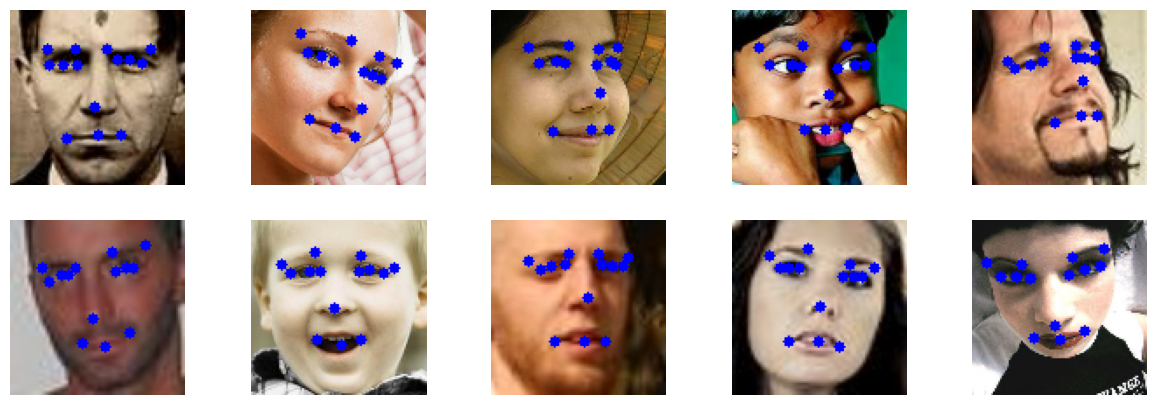

In [10]:
display_multiple_images(ds_train, 10, MEAN_DATASET, STD_DATASET)

In [11]:
dl_train=data.DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count(),
)
dl_valid=data.DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count(),
)

In [12]:
class MyModel(nn.Sequential):
    def __init__(self):
        super().__init__()
    
        self.conv1=nn.Conv2d(3, 128, 5, padding=2)
        self.bn1=nn.BatchNorm2d(128)
        self.relu1=nn.ReLU()
        self.maxpooling1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(128, 256, 3, padding=1)
        self.bn2=nn.BatchNorm2d(256)
        self.relu2=nn.ReLU()
        self.maxpooling2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(256, 512, 3, padding=1)
        self.bn3=nn.BatchNorm2d(512)
        self.relu3=nn.ReLU()
        self.maxpooling3=nn.MaxPool2d(2)
        self.conv4=nn.Conv2d(512, 512, 3, padding=1)
        self.bn4=nn.BatchNorm2d(512)
        self.relu4=nn.ReLU()
        self.maxpooling4=nn.MaxPool2d(2)
        self.flatten=nn.Flatten()
        self.dense=nn.Linear( 512* (WINDOW_SIZE[0]//16) * (WINDOW_SIZE[1]//16), 10000)
        self.relu5=nn.ReLU()
        self.dropout=nn.Dropout(0.1)
        self.dense1=nn.Linear(10000, 28)
    

In [13]:
def display_model_results(model, dataset, n=5, mean=None, std=None):
    model.eval()
    cols = min(n, 5)
    rows = (n + cols - 1) // cols  
    for row in range(rows):
        plt.figure(figsize=(15//2, 5//2))
        for i in range(cols):
            id = row * cols + i
            if id >= n:
                break
            image, _ = dataset[id]
            with torch.no_grad():
                tensor_image = image.unsqueeze(0).to(DEVICE)
                pred = model(tensor_image).squeeze().tolist()
            pred = np.array([[pred[j], pred[j+1]] for j in range(0, len(pred), 2)]).astype(np.int64)
            image_with_points = show_image_points(image, pred, mean=mean, std=std)
            plt.subplot(1, cols, i + 1)
            plt.imshow(image_with_points)
            plt.axis("off")
        plt.show()


In [ ]:

def train(num_epochs=3):
    model=MyModel().to(DEVICE)
    loss_fn=torch.nn.MSELoss().to(DEVICE)
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3)
    train_losses = []
    valid_losses = []
    for e in range(num_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in dl_train:
            x_batch=x_batch.to(DEVICE)
            y_batch=y_batch.to(torch.float32)
            y_batch=y_batch.reshape(y_batch.shape[0], -1).to(DEVICE)
            p_batch=model(x_batch)
            loss=loss_fn(p_batch, y_batch)
            train_loss.append(loss.detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss=torch.stack(train_loss).mean()
        train_losses.append(train_loss.item())
        print(
            f"Epoch {e},",
            f"train_loss: {(train_loss.item()):.8f}",
        )
        model.eval()
        valid_accs = []
        for x_batch, y_batch in dl_valid:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            with torch.no_grad():
                p_batch = model(x_batch)
            y_batch=y_batch.reshape(y_batch.shape[0], -1)
            loss=torch.nn.MSELoss()(p_batch, y_batch)
            valid_accs.append(loss.detach())
        valid_accs = torch.stack(valid_accs).mean()
        valid_losses.append(valid_accs.item())
        
        print(
            f"Epoch {e},",
            f"valid_acc: {valid_accs.item():.8f}",
        )
        if(e%100==0 or e==num_epochs-1):
            torch.save(model.state_dict(), "facepoints_model_ch.pt")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.ylim(0, min(max(max(valid_losses), max(train_losses)), 100))
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model


Epoch 0, train_loss: 102.80522156
Epoch 0, valid_acc: 32.20760564
Epoch 1, train_loss: 32.74931717
Epoch 1, valid_acc: 30.02519283
Epoch 2, train_loss: 32.71072388
Epoch 2, valid_acc: 31.14048783
Epoch 3, train_loss: 32.75781250
Epoch 3, valid_acc: 31.51915507
Epoch 4, train_loss: 33.10422516
Epoch 4, valid_acc: 30.81915446
Epoch 5, train_loss: 33.12969971
Epoch 5, valid_acc: 32.31989159
Epoch 6, train_loss: 33.76754761
Epoch 6, valid_acc: 29.62815657
Epoch 7, train_loss: 33.61476517
Epoch 7, valid_acc: 30.42328547
Epoch 8, train_loss: 32.03218460
Epoch 8, valid_acc: 39.43694374
Epoch 9, train_loss: 32.36225510
Epoch 9, valid_acc: 30.47649753
Epoch 10, train_loss: 33.96190262
Epoch 10, valid_acc: 37.64952054
Epoch 11, train_loss: 31.71795273
Epoch 11, valid_acc: 144.47627551
Epoch 12, train_loss: 25.56033897
Epoch 12, valid_acc: 33.49152669
Epoch 13, train_loss: 24.92289734
Epoch 13, valid_acc: 48.01101741
Epoch 14, train_loss: 20.79383659
Epoch 14, valid_acc: 74.98413968
Epoch 15, tra

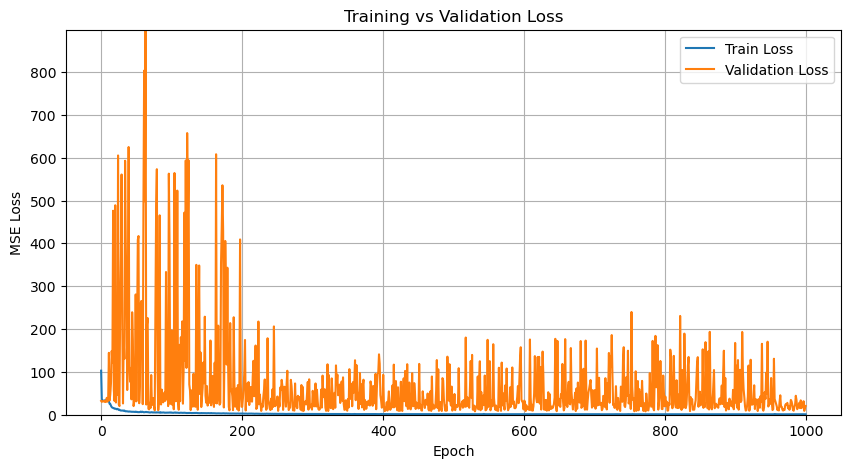

In [19]:
if(DEVICE==torch.device("cuda:0")):
    torch.cuda.empty_cache()
model=train(num_epochs=1000)

In [ ]:
model=MyModel()
model.load_state_dict(torch.load("facepoints_model_ch.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

MyModel(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running

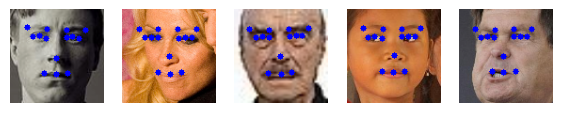

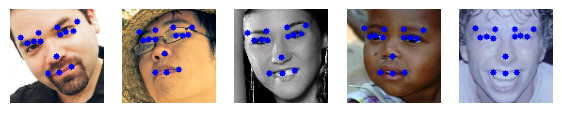

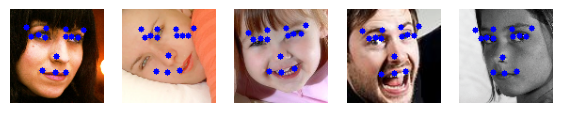

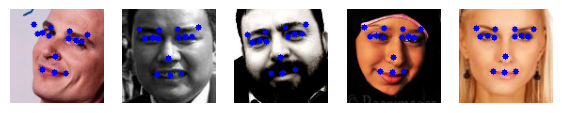

In [22]:
display_model_results(model, ds_valid, n=20, mean=MEAN_DATASET, std=STD_DATASET)

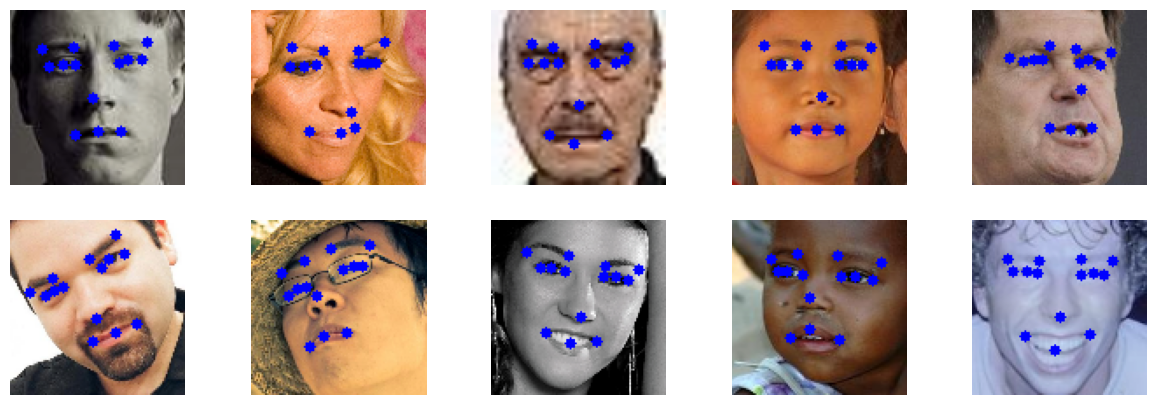

In [24]:
display_multiple_images(ds_valid, n=10, mean=MEAN_DATASET, std=STD_DATASET)

In [25]:
torch.save(model.state_dict(), "facepoints_model.pt")